# Visualisation Notebook
This notebook will take in all models, and return the train/test scores, while showing a plot of predicted vs experimental HLCs

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mpld3
mpld3.disable_notebook()
import os
import ipywidgets as widgets
from IPython.display import display
import joblib

# Bring in data, feature selections and models

In [2]:
all_data = pd.read_csv('organics_noVPAS_desc_kh.csv') # contains non-VP/AS HLCs
print("Input Shape", all_data.shape) #input shape
all_data.dropna(axis=0, inplace=True)
print("Removed NaN, new shape", all_data.shape) #removed NaN shape

#species_names = all_data.pop('Unnamed: 0')
smiles_strings = all_data.pop('SMILES')
constants_mean = all_data.pop('Kh_mean')
constants_first = all_data.pop('Kh_first')

varying_columns = all_data[['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9']] # popping one-hot encoding columns

dragon_features = all_data.drop(['Varying_1', 'Varying_2', 'Varying_3', 'Varying_4',
 'Varying_5', 'Varying_6', 'Varying_7', 'Varying_8', 'Varying_9'], axis=1) #seperating features

Input Shape (1404, 1479)
Removed NaN, new shape (1355, 1479)


In [3]:
def prediction_plot_scores(model_func, pred_df, features_list):
    """Print train+test scores, then plot scatter of predicted vs actual HLCs. Uses {X/y}_{train/test},
    redefining these variables will change the output."""
    print('Training Score:\t', model_func.score(X_train[features_list], y_train))
    print('Testing Score:\t', model_func.score(X_test[features_list], y_test))
    fig = plt.figure(figsize=(10, 10))
    scatter = plt.scatter(pred_df['Experimental'], pred_df['Predicted'])
    plt.xlabel('Experimental')
    plt.ylabel('Predicted')
    plt.title('%s predictions of HLCs' %str(model_func).split(sep='(')[0])
    labels = ['{}'.format(i) for i in species_names]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)
    plt.plot([-30, 10], [-30, 10], c='red')
    plt.show()

# Set up function to view all models
## Dict containing sets of models, with dataset types as keys

In [4]:
path_dict = {} #dict holding each dataset type as keys, and lists of model set dirs as values.
for dataset in os.listdir("models/"):
    path_list = []
    for i in range(1, 4):
        set_n = "set_" + str(i)
        path_list.append("models/%s/%s/"%(dataset, set_n))
    path_dict.update({dataset:path_list})
display(path_dict)

{'DRAGON_noVPAS': ['models/DRAGON_noVPAS/set_1/',
  'models/DRAGON_noVPAS/set_2/',
  'models/DRAGON_noVPAS/set_3/'],
 'DRAGON_VPAS': ['models/DRAGON_VPAS/set_1/',
  'models/DRAGON_VPAS/set_2/',
  'models/DRAGON_VPAS/set_3/'],
 'PCA_DRAGON_noVPAS': ['models/PCA_DRAGON_noVPAS/set_1/',
  'models/PCA_DRAGON_noVPAS/set_2/',
  'models/PCA_DRAGON_noVPAS/set_3/'],
 'PCA_DRAGON_VPAS': ['models/PCA_DRAGON_VPAS/set_1/',
  'models/PCA_DRAGON_VPAS/set_2/',
  'models/PCA_DRAGON_VPAS/set_3/'],
 'RDKit_noVPAS': ['models/RDKit_noVPAS/set_1/',
  'models/RDKit_noVPAS/set_2/',
  'models/RDKit_noVPAS/set_3/'],
 'RDKit_VPAS': ['models/RDKit_VPAS/set_1/',
  'models/RDKit_VPAS/set_2/',
  'models/RDKit_VPAS/set_3/']}

## Creating file path lists

In [5]:
for dataset in path_dict:
    for i in range(0, len(path_dict[dataset])):
        file_path = path_dict[dataset][i]
        exec('paths_%s = []'%dataset)
        exec('%s_model_list_%s = []'%(dataset, str(i)))
        exec('%s_importances_list_%s = []'%(dataset, str(i)))
        exec('%s_train_test_list_%s = []'%(dataset, str(i)))
        for file in os.listdir(file_path):
            if '.' in file:
                if file.split(sep='.')[1] == 'joblib':
                    if 'importances' in file:
                        eval('%s_importances_list_%s.append(file_path + file)'%(dataset, str(i)))
                    else:
                        eval('%s_model_list_%s.append(file_path + file)'%(dataset, str(i)))
            if 'csv' in file:
                eval('%s_train_test_list_%s.append(file_path + file)'%(dataset, str(i)))
    
for file_list in dir():
    if file_list[0:13] == 'DRAGON_noVPAS':
        paths_DRAGON_noVPAS.append(file_list)
    if file_list[0:11] == 'DRAGON_VPAS':
        paths_DRAGON_VPAS.append(file_list)
    if file_list[0:17] == 'PCA_DRAGON_noVPAS':
        paths_PCA_DRAGON_noVPAS.append(file_list)
    if file_list[0:15] == 'PCA_DRAGON_VPAS':
        paths_PCA_DRAGON_VPAS.append(file_list)
    if file_list[0:10] == 'RDKit_VPAS':
        paths_RDKit_VPAS.append(file_list)
    if file_list[0:12] == 'RDKit_noVPAS':
        paths_RDKit_noVPAS.append(file_list)

In [6]:
paths_RDKit_noVPAS

['RDKit_noVPAS_importances_list_0',
 'RDKit_noVPAS_importances_list_1',
 'RDKit_noVPAS_importances_list_2',
 'RDKit_noVPAS_model_list_0',
 'RDKit_noVPAS_model_list_1',
 'RDKit_noVPAS_model_list_2',
 'RDKit_noVPAS_train_test_list_0',
 'RDKit_noVPAS_train_test_list_1',
 'RDKit_noVPAS_train_test_list_2']

## Loading files into this session

In [7]:
for dataset in path_dict:
    for file_list in eval('paths_%s'%dataset):
        file_path_list = (eval(file_list))
        for file in file_path_list:
            filename = (file.split(sep='/')[3])
            set_n = (file.split(sep='/')[2])
            if not 'importances' in filename:
                if not 'csv' in filename:
                    if not 'pca_fit' in filename:
                        model = (filename.split(sep='_')[0])
                        features = filename.split(sep='_')[1]
                        exec('%s_%s_%s_%s = joblib.load(file)'%(dataset, model, features, set_n))
            if 'importances' in filename:
                #print(filename, set_n, "\n", file)
                imp_type = filename.split(sep='_')[0]
                exec('%s_importances_%s_%s = joblib.load(file)'%(dataset, imp_type, set_n))
            if 'csv' in filename:
                data_type = (filename.split(sep='.')[0])
                if 'X' in filename:
                    exec('%s_data_%s_%s = pd.read_csv(file)'%(dataset, data_type, set_n))
                if 'y' in filename:
                    exec('%s_data_%s_%s = pd.read_csv(file, header=None)'%(dataset, data_type, set_n))
                    exec('%s_data_%s_%s.drop(0, axis=1, inplace=True)'%(dataset, data_type, set_n))
            if 'pca_fit' in filename:
                data_type = filename.split(sep='.')[0]
                exec('%s_data_%s_%s = joblib.load(file)'%(dataset, data_type, set_n))

In [8]:
model_types = ['GradientBoostingRegressor', 'DecisionTreeRegressor', 
               'ElasticNet', 'AdaBoostRegressor', 
               'Lars', 'Lasso', 'RandomForestRegressor']
dataset_types = ['DRAGON_noVPAS', 'DRAGON_VPAS', 'PCA_DRAGON_noVPAS', 'PCA_DRAGON_VPAS', 'RDKit_VPAS', 'RDKit_noVPAS']
set_n_types = ['set_1', 'set_2', 'set_3']
feature_sets = ['model', 'freg', 'mutual', 'lasso']
feature_model_sets = ['model', 'kbest', 'mutual', 'lasso']
feature_name_link_dict = dict(zip(feature_sets, feature_model_sets))

# Export average train and test scores

In [9]:
ave_train_scores = [] ; ave_test_scores = [] ; ave_model_list = []
for Dataset in dataset_types:
    if 'PCA' in Dataset:
        for Model in model_types:
            set_train_scores = [] ; set_test_scores = []
            for Set in set_n_types:
                i = Set.split(sep='_')[1]
                X_train_ = eval(Dataset + "_data_X_train_" + Set)
                X_train = X_train_.drop('Unnamed: 0', axis=1)
                X_test_ = eval(Dataset + "_data_X_test_" + Set)
                X_test = X_test_.drop('Unnamed: 0', axis=1)
                y_train = eval(Dataset + "_data_" + 'y_train'  + "_" + Set)
                y_test = eval(Dataset + "_data_" + 'y_test'  + "_" + Set)
                model = eval(Dataset + "_" + Model + "__" + Set)
                set_train_scores.append(np.array(model.score(X_train, y_train)))
                set_test_scores.append(np.array(model.score(X_test, y_test)))
            ave_train_scores.append(np.mean(set_train_scores))
            ave_test_scores.append(np.mean(set_test_scores))
            ave_model_list.append(Dataset + "_" + Model)
    if not 'PCA' in Dataset:
        for Model in model_types:
            for feature_set in feature_sets:
                set_train_scores = []; set_test_scores = []
                for Set in set_n_types:
                    #print(Dataset, Model, feature_set, Set)
                    X_train_ = eval(Dataset + "_data_X_train_main_" + Set)
                    X_train = X_train_.drop('Unnamed: 0', axis=1)
                    X_test_ = eval(Dataset + "_data_X_test_main_" + Set)
                    X_test = X_test_.drop('Unnamed: 0', axis=1)
                    y_train = eval(Dataset + "_data_" + 'y_train'  + "_" + Set)
                    y_test = eval(Dataset + "_data_" + 'y_test'  + "_" + Set)
                    model = eval(Dataset + "_" + Model + "_" + feature_name_link_dict[feature_set] + "_" + Set)
                    chosen_features = list(eval(Dataset + "_importances_" + feature_set + "_" + Set).nlargest(15).index.values)
                    set_train_scores.append(model.score(X_train[chosen_features], y_train))
                    set_test_scores.append(model.score(X_test[chosen_features], y_test))
                ave_train_scores.append(np.mean(set_train_scores))
                ave_test_scores.append(np.mean(set_test_scores))
                ave_model_list.append(Dataset + "_" + Model + "_" + feature_set)

#av_models_DRAGON_noVPAS = pd.DataFrame(np.array(ave_model_list[0:28]).reshape(7, 4))
#av_models_DRAGON_VPAS = pd.DataFrame(np.array(ave_model_list[28:56]).reshape(7, 4))
#av_models_PCA_DRAGON_noVPAS = pd.DataFrame(np.array(ave_model_list[56:63]).reshape(7))
#av_models_PCA_DRAGON_VPAS = pd.DataFrame(np.array(ave_model_list[63:70]).reshape(7))
#av_models_RDKit_VPAS = pd.DataFrame(np.array(ave_model_list[70:98]).reshape(7, 4))
#av_models_RDKit_noVPAS = pd.DataFrame(np.array(ave_model_list[98:126]).reshape(7, 4))

av_train_DRAGON_noVPAS = pd.DataFrame(np.array(ave_train_scores[0:28]).reshape(7, 4))
av_train_DRAGON_VPAS = pd.DataFrame(np.array(ave_train_scores[28:56]).reshape(7, 4))
av_train_PCA_DRAGON_noVPAS = pd.DataFrame(np.array(ave_train_scores[56:63]).reshape(7))
av_train_PCA_DRAGON_VPAS = pd.DataFrame(np.array(ave_train_scores[63:70]).reshape(7))
av_train_RDKit_VPAS = pd.DataFrame(np.array(ave_train_scores[70:98]).reshape(7, 4))
av_train_RDKit_noVPAS = pd.DataFrame(np.array(ave_train_scores[98:126]).reshape(7, 4))

av_test_DRAGON_noVPAS = pd.DataFrame(np.array(ave_test_scores[0:28]).reshape(7, 4))
av_test_DRAGON_VPAS = pd.DataFrame(np.array(ave_test_scores[28:56]).reshape(7, 4))
av_test_PCA_DRAGON_noVPAS = pd.DataFrame(np.array(ave_test_scores[56:63]).reshape(7))
av_test_PCA_DRAGON_VPAS = pd.DataFrame(np.array(ave_test_scores[63:70]).reshape(7))
av_test_RDKit_VPAS = pd.DataFrame(np.array(ave_test_scores[70:98]).reshape(7, 4))
av_test_RDKit_noVPAS = pd.DataFrame(np.array(ave_test_scores[98:126]).reshape(7, 4))

for obj in dir():
    if obj[0:9] == 'av_models':
        df = eval(obj)
        df.rename({0:'GradientBoostingRegressor',
                   1:'DecisionTreeRegressor',
                   2:'ElasticNet',
                   3:'AdaBoostRegressor',
                   4:'Lars',
                   5:'Lasso',
                   6:'RandomForestRegressor'}, inplace=True)
        if not 'PCA' in obj:
            df.rename({0:'Model', 1:'F-regression', 2:'Mutual Information', 3:'Lasso'}, inplace=True, axis=1)
        else:
            df.rename({0:'PCA'}, axis=1, inplace=True)
    if obj[0:8] == 'av_train':
        df = eval(obj)
        df.rename({0:'GradientBoostingRegressor',
                   1:'DecisionTreeRegressor',
                   2:'ElasticNet',
                   3:'AdaBoostRegressor',
                   4:'Lars',
                   5:'Lasso',
                   6:'RandomForestRegressor'}, inplace=True)
        if not 'PCA' in obj:
            df.rename({0:'Model', 1:'F-regression', 2:'Mutual Information', 3:'Lasso'}, inplace=True, axis=1)
        else:
            df.rename({0:'PCA'}, axis=1, inplace=True)
        df.to_csv('scores/%s.csv'%obj)
    if obj[0:7] == 'av_test':
        df = eval(obj)
        df.rename({0:'GradientBoostingRegressor',
                   1:'DecisionTreeRegressor',
                   2:'ElasticNet',
                   3:'AdaBoostRegressor',
                   4:'Lars',
                   5:'Lasso',
                   6:'RandomForestRegressor'}, inplace=True)
        if not 'PCA' in obj:
            df.rename({0:'Model', 1:'F-regression', 2:'Mutual Information', 3:'Lasso'}, inplace=True, axis=1)
        else:
            df.rename({0:'PCA'}, axis=1, inplace=True)
        df.to_csv('scores/%s.csv'%obj)

In [10]:
for Dataset in dataset_types:
    for obj in dir():
        if Dataset in obj:
            if obj.endswith("train_" + Dataset):
                df_train = eval(obj)
            if obj.endswith("test_" + Dataset):
                df_test = eval(obj)
    exec("train_test_scores_%s = pd.concat([av_train_%s, av_test_%s], axis=1, keys=['Train', 'Test'])"%(Dataset, Dataset, Dataset))

# Widget

In [11]:
@widgets.interact()
def show_model(Dataset = dataset_types,
               Model = model_types,
               Features = feature_sets,
              Show_Features = False):
    widget_av_train = eval("train_test_scores_" + Dataset)
    display(widget_av_train)
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))
    ax_num = 1
    if 'PCA' in Dataset:
        X_train_holder = 'X_train'
        X_test_holder = 'X_test'
        Features = 'PCA'
        
        for Set in set_n_types:
            X_train_ = eval(Dataset + "_data_" + X_train_holder  + "_" + Set)
            X_train = X_train_.drop('Unnamed: 0', axis=1)
            X_test_ = eval(Dataset + "_data_" + X_test_holder  + "_" + Set)
            X_test = X_test_.drop('Unnamed: 0', axis=1)
            y_train = eval(Dataset + "_data_" + 'y_train'  + "_" + Set)
            y_test = eval(Dataset + "_data_" + 'y_test'  + "_" + Set)
            chosen_model = eval(Dataset + "_" + Model + "__" + Set)
            train_predictions = chosen_model.predict(X_train)
            test_predictions = chosen_model.predict(X_test)
            axs[0, ax_num].scatter(y_train, train_predictions, s=3, c='b')
            axs[0, ax_num].set_title(Set)
            axs[0, ax_num].set_xlabel('Expected log($K_H$)')
            axs[0, ax_num].set_ylabel('Predicted log($K_H$)')
            axs[1, ax_num].scatter(y_test, test_predictions, s=3, c='r')
            axs[1, ax_num].set_xlabel('Expected log($K_H$)')
            axs[1, ax_num].set_ylabel('Predicted log($K_H$)')

            ax_num += 1
        axs[0, 0].text(0.4, 0.4, 'Train data', fontsize=22)
        axs[0, 0].get_xaxis().set_visible(False)
        axs[0, 0].get_yaxis().set_visible(False)
        axs[1, 0].text(0.4, 0.4, 'Test data', fontsize=22)
        axs[1, 0].get_xaxis().set_visible(False)
        axs[1, 0].get_yaxis().set_visible(False)
        
    else:
        X_train_holder = 'X_train_main'
        X_test_holder = 'X_test_main'
        for Set in set_n_types:
            X_train = eval(Dataset + "_data_" + X_train_holder  + "_" + Set)
            X_test = eval(Dataset + "_data_" + X_test_holder  + "_" + Set)
            y_train = eval(Dataset + "_data_" + 'y_train'  + "_" + Set)
            y_test = eval(Dataset + "_data_" + 'y_test'  + "_" + Set)

            chosen_model = eval(Dataset + "_" + Model + "_" + feature_name_link_dict[Features] + "_" + Set)
            feature_set = list(eval(Dataset + "_importances_" + Features + "_" + Set).nlargest(15).index.values)

            
            # add feature lists as numpy array, then turn into a (3, 5) dataframe to append to train/test scores
            if Show_Features == True:
                feature_df = pd.DataFrame(np.array(feature_set).reshape(3, 5))
                feature_df.rename({0:'Most Imporant', 1:'', 2:Set, 3:'', 4:'Least Important'},
                                  axis=1, inplace=True)
                exec('feature_df_%s = feature_df'%Set)
            
            
            train_predictions = chosen_model.predict(X_train[feature_set])
            test_predictions = chosen_model.predict(X_test[feature_set])
            axs[0, ax_num].scatter(y_train, train_predictions, s=3, c='b')
            axs[0, ax_num].set_title(Set, fontsize=20)
            axs[0, ax_num].set_xlabel('Expected log($K_H$)')
            axs[0, ax_num].set_ylabel('Predicted log($K_H$)')
            axs[1, ax_num].scatter(y_test, test_predictions, s=3, c='r')
            axs[1, ax_num].set_xlabel('Expected log($K_H$)')
            axs[1, ax_num].set_ylabel('Predicted log($K_H$)')

            ax_num += 1
        axs[0, 0].text(0.4, 0.4, 'Train data', fontsize=22)
        axs[0, 0].get_xaxis().set_visible(False)
        axs[0, 0].get_yaxis().set_visible(False)
        axs[1, 0].text(0.4, 0.4, 'Test data', fontsize=22)
        axs[1, 0].get_xaxis().set_visible(False)
        axs[1, 0].get_yaxis().set_visible(False)
            
    if not 'PCA' in Dataset:
        if Show_Features == True:
            for Set in set_n_types:
                display(eval('feature_df_%s'%Set))
    plt.show()


interactive(children=(Dropdown(description='Dataset', options=('DRAGON_noVPAS', 'DRAGON_VPAS', 'PCA_DRAGON_noV…

non-constant variance - [heteroscatisity](http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html)
see if any models can deal with non constant variance
comment on growing error with low Kh - limiting factors?

PCA - skree plot of variance covered by components, seems similar to the feature importance graph?

for diss:
- comment on the notebooks themselves, how I've put my UI together etc
- on chemical background, explain important features in some detail - if i can
- when setting context - why are HLCs useful

talk about thermodynamic cycle - solid to gas to solution
 lattice energy, hydration energy etc - must consider crystal 

add supp. material containing datasets and notebooks
 
future work - look into solubility data, construct a cycle of solubilty for species to better describe the species activity

# Scree plot for PCA
Showing how much variance is explained as more components are added

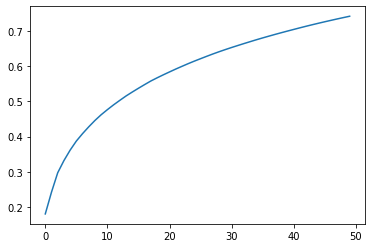

In [13]:
plt.plot(np.cumsum(PCA_DRAGON_noVPAS_data_pca_fit_set_3.explained_variance_ratio_))